english: 
    
    更新后（更改读取json文件方式）：
    总sample数：23952；总template数：29321;（包括被旧算法拒识的template)
    有效template数：26042；其中正样本数：23881；负样本数：2161
math:
    
    更新后（更改读取json文件方式）：
    总sample数：15460；总template数：19511;（包括被旧算法拒识的template)
    有效template数：18648；其中正样本数：15468；负样本数：3180

    注意！！有的sample没有与之匹配的template（标注错误数据，被自带的拒识功能拒识掉了）

    旧算法召回率计算方法：（总template数 - 有效template数） / （总template数 - 其中正样本数）

新算法测评（学科加在一起）：
    ratio阈值设置为0.1
    Precion = tp / (tp + fp)
    
    

In [3]:
#calculate tp, fp and fn
fake_r = english_fake_r + math_fake_r
all_r = math_real_r+english_real_r+math_fake_r + english_fake_r
tp = [x for x in fake_r if x <= 0.05]
tp_fp = [x for x in all_r if x <= 0.05]
print("tp = {}".format(len(tp)))
print("tp + fp = {}".format(len(tp_fp)))
print("tp+tn= {}".format(len(fake_r)))

NameError: name 'english_fake_r' is not defined

In [ ]:
#output fp
difficult = [x[3] for x in fake_rdi if x[0] > 0.1]
with open("/home/alien_yhl/workspace/img_align/test/math_fn_ratio0.1.txt", 'w') as f:
    f.writelines('\n'.join(difficult))
print(len(difficult))

211


In [ ]:
#output negative_templates
print(len(real_rdi))
print(len(fake_rdi))
y = ["{}\t{}".format(x[3], x[0]) for x in fake_rdi]
with open("/home/alien_yhl/data/negative_templates.txt", 'w') as f:
    f.writelines('\n'.join(y))

42411
31463


In [29]:
import glob
import json
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt

# json_list = glob.glob("/home/alien_yhl/data/results_6w/"+"*_result.json")
# json_list = glob.glob("/home/alien_yhl/downloads/results_json/math_15460/"+"*_result.json")
# json_list = glob.glob("/home/alien_yhl/workspace/img_align/logs/img_align_no_results_v2/"+"*_result.json")
json_list = glob.glob("/home/alien_yhl/downloads/results_json/english_23952/"+"*_result.json")

print(len(json_list))

#calculate euclidean distance
dists = []
failures = []
special = []
rdi = []
for js in tqdm(json_list):
    with open(js, 'r') as f:
        data = json.load(f)
    alignment_results = data["alignment_results"]
    try:
        mark = 0
        for i in alignment_results.keys():
            sample_mkpts = alignment_results[i]["matched_features"]["sample_mkpts"]
            template_mkpts = alignment_results[i]["matched_features"]["template_mkpts"]
            ratio = alignment_results[i]["matched_features"]["mkpts_ratio2template"]
            template_kpts_count = alignment_results[i]["template_features"]["template_kpts_count"]
            isGT = alignment_results[i]["isGroundTruthTemplate"]
            mkpts_conf = alignment_results[i]["matched_features"]["mkpts_conf"]
            aver_conf = sum(mkpts_conf) / len(mkpts_conf)

            if isGT == 1:
                mark += 1
            
            dist = 0; weighted_dist = 0;
            modified_ratio = (len(mkpts_conf) - 10) / template_kpts_count
            if len(sample_mkpts) != len(template_mkpts):
                print("length not same".format(data["id"]))
                
            for j in range(len(sample_mkpts)):
                
                dist += distance.euclidean(sample_mkpts[j], template_mkpts[j])
                weighted_dist += distance.euclidean(sample_mkpts[j], template_mkpts[j])*mkpts_conf[j]
                dist = dist / (j+1); weighted_dist = weighted_dist / (j+1);

            dists.append(dist)
            rdi.append((ratio, dist, isGT, data["id"], weighted_dist, aver_conf, i, modified_ratio)) ####MOST IMPORTANT!

        if mark > 1:
            special.append(data["id"])
    except:
        failures.append(data["id"])
print(len(rdi))
print(len(failures))
print(len(special))
real_rdi = [x for x in rdi if x[2] == 1]
fake_rdi = [x for x in rdi if x[2] == 0]

if len(special) > 0:
    repeated = [real_rdi[i+1] for i in range(len(real_rdi[:-1])) if real_rdi[i][3] == real_rdi[i+1][3]]
    for i in repeated:
        real_rdi.remove(i)
print("After delete repeats: {}".format(len(real_rdi)))


23952


100%|██████████| 23952/23952 [10:07<00:00, 39.43it/s]


26042
0
0
After delete repeats: 23881


In [31]:
#save data
def save_data(rdi, path):
    rdi = ['\t'.join(map(str, x)) for x in rdi]
    with open(path, 'w') as f:
        f.writelines('\n'.join(rdi))
save_data(real_rdi, "/home/alien_yhl/data/save_data/english_23952/real.txt")
save_data(fake_rdi, "/home/alien_yhl/data/save_data/english_23952/fake.txt")

In [48]:
#read data
def read_data(path):
    with open(path, 'r') as f:
        rdi = f.readlines()
    rdi = [ x.strip().split('\t') for x in rdi]
    # real_rdi = [x for x in rdi if int(x[2]) == 1]
    # fake_rdi = [x for x in rdi if int(x[2]) == 0]
    return rdi
math_real_rdi = read_data("/home/alien_yhl/data/save_data/math_15460/real.txt")
math_fake_rdi = read_data("/home/alien_yhl/data/save_data/math_15460/fake.txt")


120


In [ ]:
#analysis data
dif = [x for x in math_real_rdi if float(x[0])>0.1 and float(x[7])<=0.1]
dif_fake = [x[3] for x in math_fake_rdi if float(x[0])>0.1 and float(x[7])<=0.1]
with open("/home/alien_yhl/workspace/img_align/test/ratio_modify_dif_fake.txt", 'w') as f:
    f.writelines('\n'.join(dif_fake))
print(len(dif_fake))

SyntaxError: unexpected EOF while parsing (<string>, line 1)

In [32]:
#evaluate from ratio<0.1 to modified_ratio<0.1,
#main index: precision and recall
def old_ratio_access(ratio):
    tp = [x for x in fake_rdi if x[0] <= ratio]
    fp = [x for x in real_rdi if x[0] <= ratio]
    fn = [x for x in fake_rdi if x[0] > ratio]
    p = len(tp) / (len(tp) + len(fp))
    r = len(tp) / (len(tp) + len(fn))
    print("Old ratio access: Precision: {:.2%}; Recall: {:.2%}".format(p, r))
def new_ratio_access(ratio):
    tp = [x for x in fake_rdi if x[7] <= ratio]
    fp = [x for x in real_rdi if x[7] <= ratio]
    fn = [x for x in fake_rdi if x[7] > ratio]
    p = len(tp) / (len(tp) + len(fp))
    r = len(tp) / (len(tp) + len(fn))
    print("New ratio access: Precision: {:.2%}; Recall: {:.2%}".format(p, r))
old_ratio_access(0.1)
new_ratio_access(0.1)

Old ratio access: Precision: 99.13%; Recall: 94.77%
New ratio access: Precision: 99.09%; Recall: 95.37%


In [34]:
dif = [x for x in real_rdi if x[0]>0.1 and x[7]<=0.1]
print(dif)


[(0.107421875, 2.6812003747075597, 1, '48cfcd81-de03-433d-a2ea-650ce27dc13c', 2.417894720840931, 0.8045035243034363, '0', 0.09765625)]


In [ ]:
#output 6w_results_part1_v2.txt
print(len(real_rdi))

real_sam = ["{}\t{}\t{}".format(x[3], x[6], x[0]) for x in real_rdi]
with open("/home/alien_yhl/data/6w_results_part1_v2.txt", 'w') as f:
    f.writelines('\n'.join(real_sam))

1942


In [ ]:
real_name = [x[3] for x in real_rdi]
print(len(real_name))
new_name = list(real_name)
for i in list(set(real_name)):
    new_name.remove(i)
print(new_name)

1942
['e43717ae-bb48-401d-a835-00b928f52335']


In [ ]:
output_withoutgt = {}
for data in fake_rdi:
    if data[3] not in real_name:
        if data[3] not in output_withoutgt.keys() or output_withoutgt[data[3]]["ratio"] < data[0]:
            output_withoutgt[data[3]] = {
                "temp_index": data[6],
                "ratio": data[0]
            }
print(len(output_withoutgt.keys()))
output_withoutgt_list = ["{}\t{}\t{}".format(x, output_withoutgt[x]["temp_index"], output_withoutgt[x]["ratio"]) for x in output_withoutgt.keys()]
print(len(output_withoutgt_list))

1292
1292


In [ ]:
with open("/home/alien_yhl/data/6w_results_part1_v2.txt", 'a') as f:
    f.write('\n')
    f.writelines('\n'.join(output_withoutgt_list))

In [ ]:
#analysis why some file read fail
with open("/home/alien_yhl/data/6w_results_part1_v2.txt", 'r') as f:
    new_dt = f.readlines()
new_dt = [x[0:36] for x in new_dt]
print(len(new_dt))
print(new_dt[0:3])

with open("/home/alien_yhl/data/6w_results_part1.txt", 'r') as f:
    old_dt = f.readlines()
old_dt = [x[0:36] for x in old_dt]
print(len(old_dt))
print(old_dt[0:3])
for i in old_dt:
    if i in new_dt:
        continue
    else:
        print(i)

3233
['e1c99c38-6e32-4b85-9b13-b062a2046655', 'd281806f-4225-41a9-ad6c-f9f59ff3b6e3', 'd0db1d6b-b7f2-4c09-8a8a-5897eb8514aa']
3242
['d0ff010f-65ca-4a1e-a524-60a226cf3ee0', 'd055e3cd-8ad2-4008-901d-103fe10fe196', 'd0474dd0-4df8-435f-96da-2f7cb5c2d4e6']
d1156684-3b93-4236-84ea-62ac27d8e41d
d5aff270-2711-4ccf-ad59-378520e21114
d1f853e2-e00b-49bc-a7d9-a789f1489c69
d3fe3338-9b38-49ba-8c52-6a9d5d1afcd7
d46fa06b-ef48-4f32-b2f1-13f5b4fbc6c1
d5742d7a-9903-45b7-ad82-d1bb3c4484ca
de89d47a-1304-4266-abe9-c743f9004c69
e2734ccb-f29a-48b9-ba37-e0c4f32e72c6
e272b818-ddef-40c2-94a4-4b457984cd92


In [ ]:
len('e369a6fa-259d-4599-abca-af9b91e6458a')

36

In [ ]:
math_real_rdi = [x for x in real_rdi]
math_fake_rdi = [x for x in fake_rdi]
math_real_d = [x[1] for x in math_real_rdi]
math_fake_d = [x[1] for x in math_fake_rdi]
math_real_conf = [x[5] for x in math_real_rdi]
math_fake_conf = [x[5] for x in math_fake_rdi]


In [ ]:
english_real_rdi = [x for x in real_rdi]
english_fake_rdi = [x for x in fake_rdi]
english_real_d = [x[1] for x in english_real_rdi]
english_fake_d = [x[1] for x in english_fake_rdi]

In [ ]:
print(len(math_real_rdi))
print(len(english_real_d))
print(min([(x[0], x[3]) for x in english_real_rdi]))
print(min([(x[0], x[3]) for x in math_real_rdi]))


23881
23881
(0.0048828125, '87843948-af0d-439f-ab7f-d93ffa4e8969')
(0.0048828125, '87843948-af0d-439f-ab7f-d93ffa4e8969')


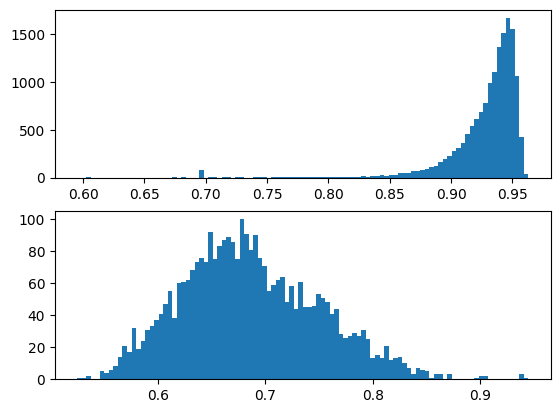

In [ ]:
figure, ax = plt.subplots(2)
ax[0].hist(math_real_conf, bins = 100)
ax[1].hist(math_fake_conf, bins = 100)
figure.show()

In [ ]:
all_rdi = math_rdi+english_rdi
print(len(all_rdi))
with open("/home/alien_yhl/data/img_retrieval_wrong/need_confirm/need_confirm.txt", 'w') as f:
    f.writelines('\n'.join(all_rdi))

In [ ]:
english_rdi = [x[3] for x in real_rdi if x[0]<0.4 or x[1] >20]
print(english_rdi[0:5])
print(len(english_rdi))
with open("/home/alien_yhl/data/img_retrieval_wrong/need_confirm/english_need_confirm.txt", 'w') as f:
    f.writelines('\n'.join(english_rdi))

In [ ]:
math_rdi = [x[3] for x in real_rdi if x[0]<0.2 or x[1] > 10 ]
print(math_rdi[0:5])
print(len(math_rdi))
with open("/home/alien_yhl/data/img_retrieval_wrong/need_confirm/math_need_confirm.txt", 'w') as f:
    f.writelines('\n'.join(math_rdi))

In [ ]:
figure, ax = plt.subplots()
ax.scatter(r,d,s = 0.2)


In [ ]:
figure, ax = plt.subplots()
ax.scatter(real_r, real_d, s = 0.2)


In [ ]:
#calculate all temps including the templates rejected by the old algrihm

import json
from tqdm import tqdm
with open("/home/alien_yhl/workspace/img_align/test/english_23952.txt", 'r') as f:
    math_list = f.readlines()
candidate = 0
for i in tqdm(math_list):
    i = i.strip()
    with open("/home/alien_yhl/data/image_retrieval/anno/"+i+".json", 'r') as f:
        data = json.load(f)
    candidate += len(data["candidate_template_images"])
print(candidate)

100%|██████████| 23952/23952 [00:16<00:00, 1419.21it/s]

29321
